In [2]:
# ====== Setup & Download ======
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download dataset
file_id = '1ckAYpVnT-wqTclxnvpld6dWp8Q1QZv7b'
gdown.download(id=file_id, output='fraudTrain.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ckAYpVnT-wqTclxnvpld6dWp8Q1QZv7b
To: d:\Kuliah\Out\deploycamp\file\ModelAPI\model\fraudTrain.csv
100%|██████████| 28.3k/28.3k [00:00<00:00, 3.13MB/s]


'fraudTrain.csv'

In [3]:
# ====== 1. Load Data ======
df = pd.read_csv("fraudTrain.csv")
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

Dataset loaded: 1000 rows × 5 columns


In [4]:
# ====== 2. Basic Info ======
print("\nBasic Info:")
print(df.info())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB
None


In [5]:
# ====== 3. Missing Values & Duplicate Rows Check ======
print("\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\nDuplicate Rows:")
duplicate = df.duplicated().sum()
print(duplicate)


Missing Values:
Series([], dtype: int64)

Duplicate Rows:
0


In [6]:
# ====== 4. Skewness Check ======
print("\nSkewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\nRecommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"{col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"{col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"{col} is fairly symmetric (skew={skew:.2f}). No action needed.")


Skewness Check:
label             4.135689
amount            1.867839
transaction_id    0.000000
dtype: float64

Recommendation:
label is highly skewed (skew=4.14). Suggest: Apply log or sqrt transform.
amount is highly skewed (skew=1.87). Suggest: Apply log or sqrt transform.
transaction_id is fairly symmetric (skew=0.00). No action needed.


In [7]:
# ====== 5. Outlier Detection (IQR Method) ======
print("\n Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers detected.")
    else:
        print(f"{col}: No significant outliers.")


 Outlier Check (IQR Method):
transaction_id: No significant outliers.
amount: 43 outliers detected.
label: 50 outliers detected.


In [8]:
# ====== 6. Correlation Analysis ======
print("\n Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f" {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")


 Correlation Matrix (Top correlated pairs):
Series([], dtype: float64)

 Recommendation:


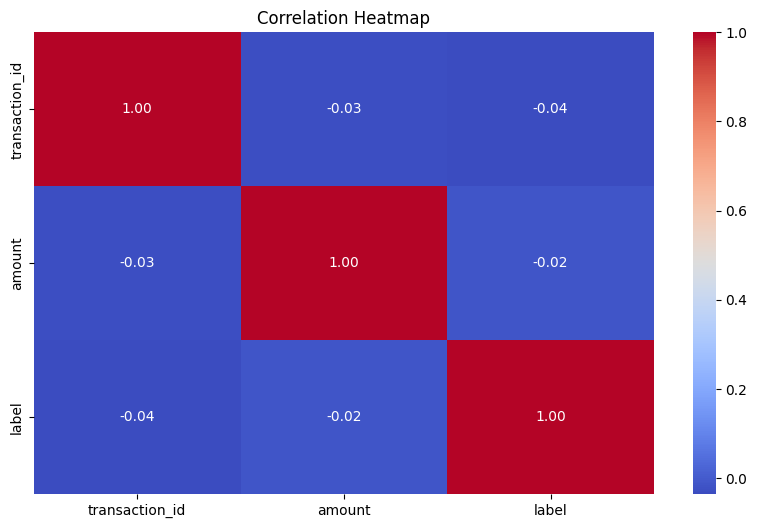

In [9]:
# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [10]:
# ====== 8. Preprocessing ======
# Log transform amount
df['amount_log'] = np.log1p(df['amount'])

# One-hot encoding
categorical_cols = ['merchant_type', 'device_type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# SMOTE preparation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['label', 'transaction_id', 'amount'])
y = df_encoded['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
# ====== 9. XGBoost Training with Low-Risk Tuning ======
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

baseline_params = {
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

param_grid = {
    'scale_pos_weight': [1, 2, 3],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

xgb_base = XGBClassifier(**baseline_params)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_res, y_res)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1}
Best CV Score: 0.7786250491965849


d:\aplikasi\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:

              precision    recall  f1-score   support

           0     0.9600    0.7579    0.8471       190
           1     0.0800    0.4000    0.1333        10

    accuracy                         0.7400       200
   macro avg     0.5200    0.5789    0.4902       200
weighted avg     0.9160    0.7400    0.8114       200



<Figure size 600x400 with 0 Axes>

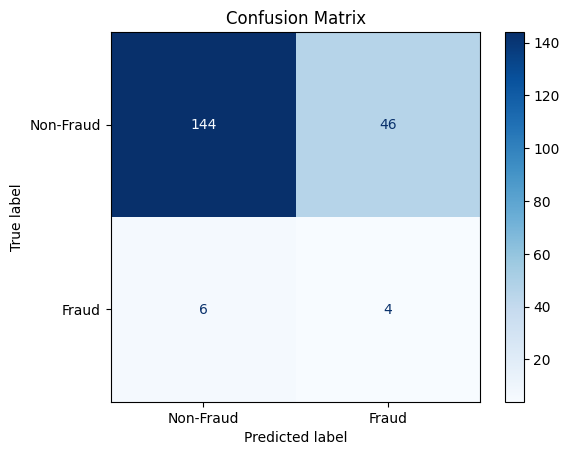

In [12]:
# ====== 10. Evaluation ======
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ====== 11. Load Sample Data Baru ======
sample_data = {
    'transaction_id': 1001,
    'amount': 104.88,
    'merchant_type': 'electronics',
    'device_type': 'tablet'
}

# DataFrame
sample_df = pd.DataFrame([sample_data])

# Amount_log
sample_df['amount_log'] = np.log1p(sample_df['amount'])

combined = pd.concat([df[['merchant_type', 'device_type']], sample_df[['merchant_type', 'device_type']]])
combined_encoded = pd.get_dummies(combined, drop_first=True)

sample_encoded = combined_encoded.iloc[[-1]].reset_index(drop=True)

numerical_cols = ['amount_log']
sample_final = pd.concat([sample_df[numerical_cols].reset_index(drop=True), sample_encoded], axis=1)

for col in X_train.columns:
    if col not in sample_final.columns:
        sample_final[col] = 0

sample_final = sample_final[X_train.columns]

# ====== 12. Prediksi ======
new_prediction = best_model.predict(sample_final)
new_proba = best_model.predict_proba(sample_final)

print(f"\n Prediksi untuk data baru:")
print(f" Label prediksi: {'Fraud' if new_prediction[0] == 1 else 'Non-Fraud'}")
print(f" Probabilitas: Non-Fraud={new_proba[0][0]:.4f}, Fraud={new_proba[0][1]:.4f}")


 Prediksi untuk data baru:
 Label prediksi: Fraud
 Probabilitas: Non-Fraud=0.1463, Fraud=0.8537


In [ ]:
import os
import pickle

os.makedirs("model", exist_ok=True)

with open("model/train_Model.pkl", "wb") as f:
    pickle.dump(best_model, f)

model_columns = list(X_train.columns)
with open("model/model_columns.pkl", "wb") as f:
    pickle.dump(model_columns, f)
